# Triples

Created by Kidror originally, refined by glumbaron.

Multipliers excluded from consideration for now: ON_FIRE, GROWTH, TRAVELING, CHUNKY, SMOOTH.

```python
def apply_threshold(row):
    if row["season"] in [11, 12]:
        # S12 and S13: not that bad...
        # multipliers work, but affinity for crows doesn't seem to affect fielders
        # grand and obt have the same coefficient, omi and visc have the same coefficient
        threshold = (
            0.05
            + 0.200 * row["gf_vibes"]
            - 0.040 * row["opw_vibes"]
            - 0.060 * row["chase_vibes"]
            + 0.020 * row["fwd_center"]
            + 0.035 * row["grand_center"]
            + 0.035 * row["obt_center"]
            - 0.005 * row["omi_center"]
            - 0.005 * row["visc_center"]
        )
    elif row["season"] in [13, 14]:
        # S14-15: slightly fiddly but it works so...
        # multipliers work, but affinity for crows doesn't seem to affect fielders
        # grand and obt have the same coefficient, omi and visc have the same coefficient
        threshold = (
            0.045
            + 0.2000 * row["gf_vibes"]
            - 0.0400 * row["opw_vibes"]
            - 0.0500 * row["chase_vibes"]
            + 0.0200 * row["fwd_center"]
            + 0.0340 * row["grand_center"]
            + 0.0340 * row["obt_center"]
            - 0.0065 * row["omi_center"]
            - 0.0065 * row["visc_center"]
        )
    return threshold
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-triples.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# seasons = [11, 12]
seasons = [11, 12, 13, 14]
# seasons = [13]
# seasons = [13, 14]
df = df[df['season'].isin(seasons)]
len(df)

49242

In [2]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # sometimes traveling doesn't do anything on pitchers, but not always
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # pass # sometimes growth doesn't do anything on pitchers, but not always
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    # if row["pitcher_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        # mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        # pass
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        mul += 2.0
    # if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # mul += 0.50
    return mul

# patch the fielder multiplier, which missed Shelled when done in resim.py (last time I ran it anyway)
def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    # if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        # mul += 0.5  # doesn't apply to fielders I guess?
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul #if mul == 0 else 1.0

df["batter_multiplier"] = df.apply(get_batter_mul, axis=1)
df["pitcher_multiplier"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_multiplier"] = df.apply(get_fielder_mul, axis=1)

In [3]:

dfc = df.copy()
for exclude_mod in ["ON_FIRE",
                    # "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "SINKING_SHIP", 
                    "GROWTH", "TRAVELING",
                    "CHUNKY", "SMOOTH",
            ]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', "batter_ground_friction"]
pitcher_params = ['pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness']
fielder_params = ['fielder_anticapitalism', 'fielder_chasiness', 'fielder_omniscience', 'fielder_tenaciousness', 'fielder_watchfulness']

for attr in batter_params:
    # pass
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    # pass
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']
for attr in fielder_params:
    # pass
    dfc[attr] = dfc[attr] * df['fielder_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

# dfc = dfc[dfc["batter_multiplier"] == 1]
# dfc = dfc[dfc["pitcher_multiplier"] == 1]
# dfc = dfc[dfc["fielder_multiplier"] == 1]

dfc["gf_vibes"] = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["chase_vibes"] = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
dfc["fwd_center"] = dfc["ballpark_forwardness"] - 0.5
dfc["grand_center"] = dfc["ballpark_grandiosity"] - 0.5
dfc["obt_center"] = dfc["ballpark_obtuseness"] - 0.5
dfc["visc_center"] = dfc["ballpark_viscosity"] - 0.5
dfc["omi_center"] = dfc["ballpark_ominousness"] - 0.5

dfc["grandobt"] =  dfc["grand_center"] + dfc["obt_center"]
dfc["omivisc"] = dfc["visc_center"] + dfc["omi_center"]


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model


X = dfc[["roll", "gf_vibes", "opw_vibes", "chase_vibes",# "supp_vibes",
         "fwd_center",
         "grandobt",
         "omivisc",
        ]].copy()
y = dfc['passed']

# # S12-13
# pin_intercept = 0.05
# # pin_intercept = None
# pins = [
#     (0.20, "gf_vibes"),
#     (-0.040, "opw_vibes"),
#     (-0.06, "chase_vibes"),
#     (0.02, "fwd_center"),
#     (0.035, "grandobt"),
#     (-0.005, "omivisc"),
# ]

# S14-15
pin_intercept = 0.045
# pin_intercept = None
pins = [
    (0.20, "gf_vibes"),
    (-0.040, "opw_vibes"),
    (-0.05, "chase_vibes"),
    (0.02, "fwd_center"),
    (0.034, "grandobt"),
    (-0.0065, "omivisc"),
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=100000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
# print(len(dfc[~dfc["passed"]]))
# print(len(dfc[dfc["passed"]]))
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

# this'll have outliers because it's trying to fit both pairs of seasons at once.
# ignore that, see below

[[35395    28]
 [   20  4827]]
48 outliers
0.9988080456915818
intercept: 0.045
(0.2, 'gf_vibes')
(-0.04, 'opw_vibes')
(-0.05, 'chase_vibes')
(0.02, 'fwd_center')
(0.034, 'grandobt')
(-0.0065, 'omivisc')


In [5]:
def apply_threshold(row):
    if row["season"] in [11, 12]:
        threshold = (
            0.05
            + 0.200 * row["gf_vibes"]
            - 0.040 * row["opw_vibes"]
            - 0.060 * row["chase_vibes"]
            + 0.020 * row["fwd_center"]
            + 0.035 * row["grand_center"]
            + 0.035 * row["obt_center"]
            - 0.005 * row["omi_center"]
            - 0.005 * row["visc_center"]
        )
    elif row["season"] in [13, 14]:
        threshold = (
            0.045
            + 0.2000 * row["gf_vibes"]
            - 0.0400 * row["opw_vibes"]
            - 0.0500 * row["chase_vibes"]
            + 0.0200 * row["fwd_center"]
            + 0.0340 * row["grand_center"]
            + 0.0340 * row["obt_center"]
            - 0.0065 * row["omi_center"]
            - 0.0065 * row["visc_center"]
        )
    return threshold

dfc["threshold"] = dfc.apply(apply_threshold, axis=1)

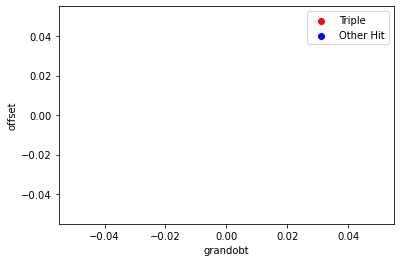

In [6]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
# x_val = "gf_vibes"
x_val = "grandobt"
y_val = "offset"
ax.scatter(
    outliers[~outliers['passed']][x_val],
    outliers[~outliers['passed']][y_val],
    color="red",
    label="Triple"
)
ax.scatter(
    outliers[outliers['passed']][x_val],
    outliers[outliers['passed']][y_val],
    color="blue",
    label="Other Hit"
)
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()


In [7]:
table = outliers
print(len(table))
table[["offset", "weather", "event_type", "batter_multiplier", "pitcher_multiplier", "fielder_multiplier",
       "roll", "threshold",
       "gf_vibes",
       "opw_vibes",
       "chase_vibes",
       # "fielder_name",
       # "batter_name", "pitcher_name",
       # "fwd_center",
       # "grand_center",
       # "obt_center",
       # "visc_center",
       "batter_mods", "pitcher_mods", "fielder_mods",
       "batting_team_mods", "pitching_team_mods",
       "season", "day",
       "game_id", "play_count",
      "ball_count","strike_count",]].sort_values('offset')

0


,offset,weather,event_type,batter_multiplier,pitcher_multiplier,fielder_multiplier,roll,threshold,gf_vibes,opw_vibes,...,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count,ball_count,strike_count


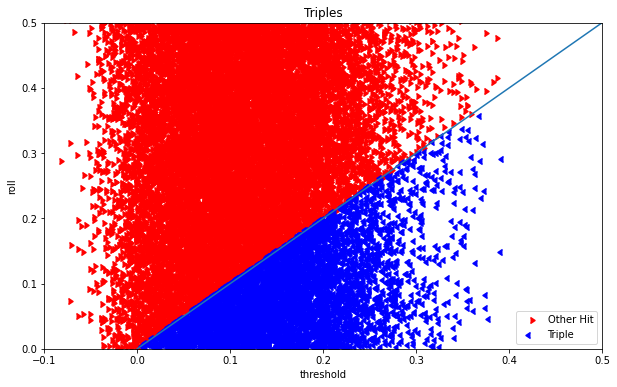

In [8]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Other Hit", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Triple", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Triples")
ax.set_xlim([-0.1, 0.5])
ax.set_ylim([0.0, 0.5])
ax.legend()

In [9]:
# print(dfc[dfc["passed"]]["roll"].max())
# print(dfc[~dfc["passed"]]["roll"].min())

In [10]:
# print(dfc[dfc["passed"]]["roll"].min())
# print(dfc[~dfc["passed"]]["roll"].max())

In [11]:
# dfc.groupby("stadium_id").size()